# Implementação de Métodos de Machine Learning
**Aluno:** Matheus Gama dos Santos - 20180163117<br>
**Curso:** Ciência da Computação - UFPB<br>
**Profª:** Thais Gaudencio do Rego<br><br>
Este projeto consiste na implementação de métodos de Machine Learning para analisar as bases de dados listadas abaixo:
- [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
- [
House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
- [2018-2019 Premier League Data
](https://www.kaggle.com/thesiff/premierleague1819)

Cada base de dados será tratada em uma das 3 seções: **Classificação**, **Regressão** e **Clusterização** (nessa ordem).<br>

## Classificação

In [2]:
#install imblearn
!pip install imblearn

In [33]:
#import modules
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import sensitivity_score, specificity_score
from string import ascii_letters
import ipywidgets as widgets

In [34]:
#load dataframe
titanic_filename = 'titanic/train.csv'
titanic_dataframe = pd.read_csv(titanic_filename)

In [35]:
titanic_dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preprocessing

In [36]:
# select useful attributes
titanic_dataframe = titanic_dataframe.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Fare"], axis=1)
titanic_dataframe.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [37]:
# converting "Sex" atribute
titanic_dataframe.Sex = titanic_dataframe.Sex.replace({'male':0, 'female':1})
titanic_dataframe.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,22.0,1,0
1,1,1,1,38.0,1,0
2,1,3,1,26.0,0,0
3,1,1,1,35.0,1,0
4,0,3,0,35.0,0,0


In [38]:
titanic_dataframe.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


<font size="3">Analisando o estado atual do *Dataframe*, observa-se que o atributo *Age* possui mais de 100 linhas sem dado. <br>Fazendo agora testes para verificar a influência das linhas com dado faltando.</font><br><br><br>

In [39]:
def get_titanic_survivability(d_frame_surv): # d_frame_surv: dataframe Survived column
    zeros = 0
    ones = 0
    for numbers in d_frame_surv:
        if numbers:
            ones += 1
        else:
            zeros += 1
    print(f"Died: {zeros} ({zeros/(zeros+ones)}), Survived: {ones} ({ones/(zeros+ones)})")

In [40]:
# Compare dataframe with and without missing data rows

# m_df will be titanic_dataframe.Survived without missing values
m_df = titanic_dataframe.dropna(axis=0)
m_df = np.array(m_df.Survived)

# dtf will be a copy of titanic_dataframe.Survived
df = np.array(titanic_dataframe.Survived)

In [41]:
# Compare results
print('Without missing values:')
get_titanic_survivability(m_df)
print('\nWith missing values:')
get_titanic_survivability(df)

Without missing values:
Died: 424 (0.5938375350140056), Survived: 290 (0.4061624649859944)

With missing values:
Died: 549 (0.6161616161616161), Survived: 342 (0.3838383838383838)


<font size="3">É possível observar que o balanceamento da base de dados, com relação ao *target* ("*Survived*"), não teve alteração significativa ao eliminar os objetos sem o valor do atributo "*Age*". Vamos comparar, por fim, o impacto nos outros atributos da base de dados.</font><br><br>

In [42]:
# description of titanic_dataframe
titanic_dataframe.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


In [43]:
# description of titanic_dataframe without the missing values
titanic_dataframe.dropna(axis=0).describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000


##### O impacto não parece ser significativo na distribuição dos outros atributos. <br><br>Agora, normalizando os dados e exibindo a matriz de correlação dos atributos relevantes.

In [44]:
titanic_dataframe = titanic_dataframe.dropna(axis=0)

# Normalizing dataframe
def normalize_df(df):
    d_values = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    d_values_scaled = min_max_scaler.fit_transform(d_values)
    df_norm = pd.DataFrame(d_values_scaled, columns=df.columns)
    return df_norm

titanic_dataframe_norm = normalize_df(titanic_dataframe)
titanic_dataframe_norm.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch
213,0.0,0.5,0.0,0.447097,0.0,0.000000
224,1.0,1.0,1.0,0.434531,0.2,0.166667
660,0.0,1.0,0.0,0.019854,0.8,0.166667
397,0.0,1.0,0.0,0.296306,0.0,0.000000
358,1.0,0.5,1.0,0.158080,0.0,0.166667


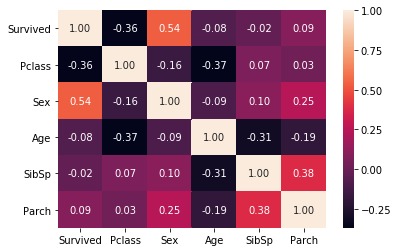

In [45]:
# Correlation Matrix
sns.heatmap(titanic_dataframe_norm.corr(), annot=True, fmt=".2f")
plt.show()

##### Em relação ao *target* ("*Survived*"), é possível perceber que as correlações mais importantes são entre a classe do indivíduo (-0.36) e o sexo (0.54). Quanto menor a classe social, mais chance de sobreviver. Também pode-se dizer que o sexo feminino tem mais chance de sobreviver, dado que sobrevivência é representada pelo valor 1 e o sexo feminino tem valor 1. As outras correlações não apresentam valores muito expressivos. <br><br>Analisando agora a presença de outliers em cada atributo.

In [46]:
titanic_dataframe.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000



Survived é um atributo binário, que também é o target, portanto seus valores tem significado classificatório. Logo, survived não possui outliers. Pclass também possui valores com significado classificatório (1, 2 ou 3), logo não possui outliers. Sex é binário e também possui significado classificatório, logo não possui outliers. Age, aparentemente possui outliers, dado que sua média tem valor aproximado de 29.6991, com desvio padrão de aproximadamente 14.5264. Se considerarmos ( $média + 2(dp)$ ), valores acima de 58.7519 podem ser considerados outliers. Porém, nesse caso, a base de dados possui valores entre 58.7519 e 80, que são valores representativos pra base de dados. Além do mais, talvez se utilizássemos ( média + 3 \* desv_pad ) não consideraríamos como outlier. O mesmo acontece com SibSp e Parch. <br><br>Para verificar as afirmações, vamos observar os gráficos de cada atributo.

In [47]:
attribute = 'Survived'
def on_change(change):
    global attribute
    if change['type'] == 'change' and change['name'] == 'value':
        attribute = change['new']

In [62]:
w = widgets.Dropdown(
    options=[e for e in titanic_dataframe.columns],
    value=titanic_dataframe.columns[0],
    description='Attribute:',
    disabled=False,
)

w.observe(on_change)

display(w)

Dropdown(description='Attribute:', options=('Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'), value='Surv…

##### Obs.: Selecione o atributo e execute as duas próximas células para exibir o histograma e boxplot

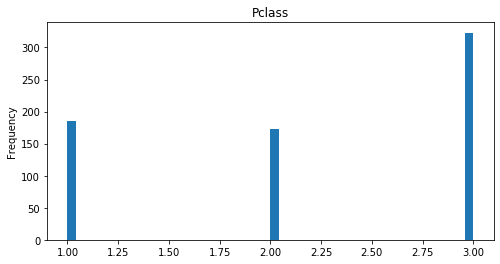

In [63]:
# Plot histogram
titanic_dataframe[attribute].plot(kind='hist',title=attribute ,bins=50,figsize=(8,4))

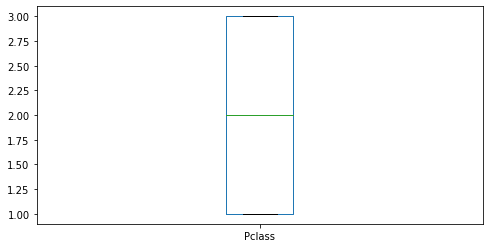

In [64]:
# Boxplot
titanic_dataframe[attribute].plot(kind='box',figsize=(8,4))

##### Ao observar os gráficos, vemos que SibSp e Parch são os atributos com verdadeiros outliers e não balanceados por essa mesma razão. Retirando então os valores acima de (média + 3 \* desv_pad).

In [51]:
# Dropping outliers
indexNames = titanic_dataframe[ (titanic_dataframe['SibSp'] > 3) | (titanic_dataframe['Parch'] > 3) ].index
titanic_dataframe.drop(indexNames , inplace=True)

# get normalized version
titanic_dataframe_norm = normalize_df(titanic_dataframe)

##### Agora temos os dados balanceados e normalizados, prontos para aplicar os modelos

In [52]:
# select features and target
y = titanic_dataframe_norm.Survived
x = titanic_dataframe_norm.drop(columns='Survived').to_numpy()

In [53]:
# split train and test
train_X, test_X, train_Y, test_Y = model_selection.train_test_split( x, y, random_state=0, test_size=.2 )

##### Os modelos escolhidos foram Random Forest e SVM

In [54]:
# Random Forest
rdf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2) #max_depth = 3, random_state=2
rdf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [55]:
pred_Y = rdf.predict(test_X)
def show_metrics(test, pred):
    # accuracy: the fraction of predictions the model got right.
    accuracy = metrics.accuracy_score(test,pred)

    # sensitivy (recall): Percentage of correct predictions out of all the positive classes. (TP / TP+FN).
    sensitivity = sensitivity_score(test,pred)
    
    # specificity: proportion of actual negatives that are correctly identified as such. (TN / FP + TN).
    specificity = specificity_score(test,pred)
    
    """>Precision (used to calculate f1 score): Out of all the positive classes predicted correctly, how many are actually positive. (TP / TP+FP)"""
    # f1 score (harmonic mean of precision and recall): an accuracy coefficient with values between 0 and 1 (0 and 1 included).
    f1_score = metrics.f1_score(test, pred)

    x = np.array([accuracy, f1_score, sensitivity, specificity]).reshape(1,4)
    return pd.DataFrame(x, columns=["Accuracy", "F1 Score","Sensitivity", "Specificity"], index=["Results"])

results_r_forest = show_metrics(test_Y, pred_Y)
results_r_forest

,Accuracy,F1 Score,Sensitivity,Specificity
Results,0.861314,0.828829,0.793103,0.911392


In [56]:
# confusion matrix
def show_confusion_mat(test,pred):
    c_mat = metrics.confusion_matrix(test, pred)
    return pd.DataFrame(c_mat, columns=["P", "N"], index=["P", "N"])
mat_r_forest = show_confusion_mat(test_Y,pred_Y)
mat_r_forest

# TP  FP
# FN  TN

,P,N
P,72,7
N,12,46


##### Random Forest...

In [57]:
# SVC
SVC = svm.SVC(gamma=11) #11
SVC.fit(train_X, train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=11, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
pred_Y = SVC.predict(test_X)
results_SVC = show_metrics(test_Y, pred_Y)
results_SVC

,Accuracy,F1 Score,Sensitivity,Specificity
Results,0.854015,0.821429,0.793103,0.898734


In [59]:
mat_SVC = show_confusion_mat(test_Y,pred_Y)
mat_SVC

,P,N
P,71,8
N,12,46


##### SVM é classificador linear binário não probabilístico que tenta definir um reta que melhor separa as classes do problema. O fato dos dados estarem relativamente balanceados e só possuírem apenas duas classificações foi a justificativa para a escolha desse algoritmo. Os resultados foram bem satisfatórios, com acurácia de 0,854015 e F1-Score de 0,821429. Os números de acertos positivos e negativos também encontrou altas taxas, com sensibilidade de 0,793103 e especificidade de 0,898734.